Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


Set the default float type to float64
Set the default float type to float64


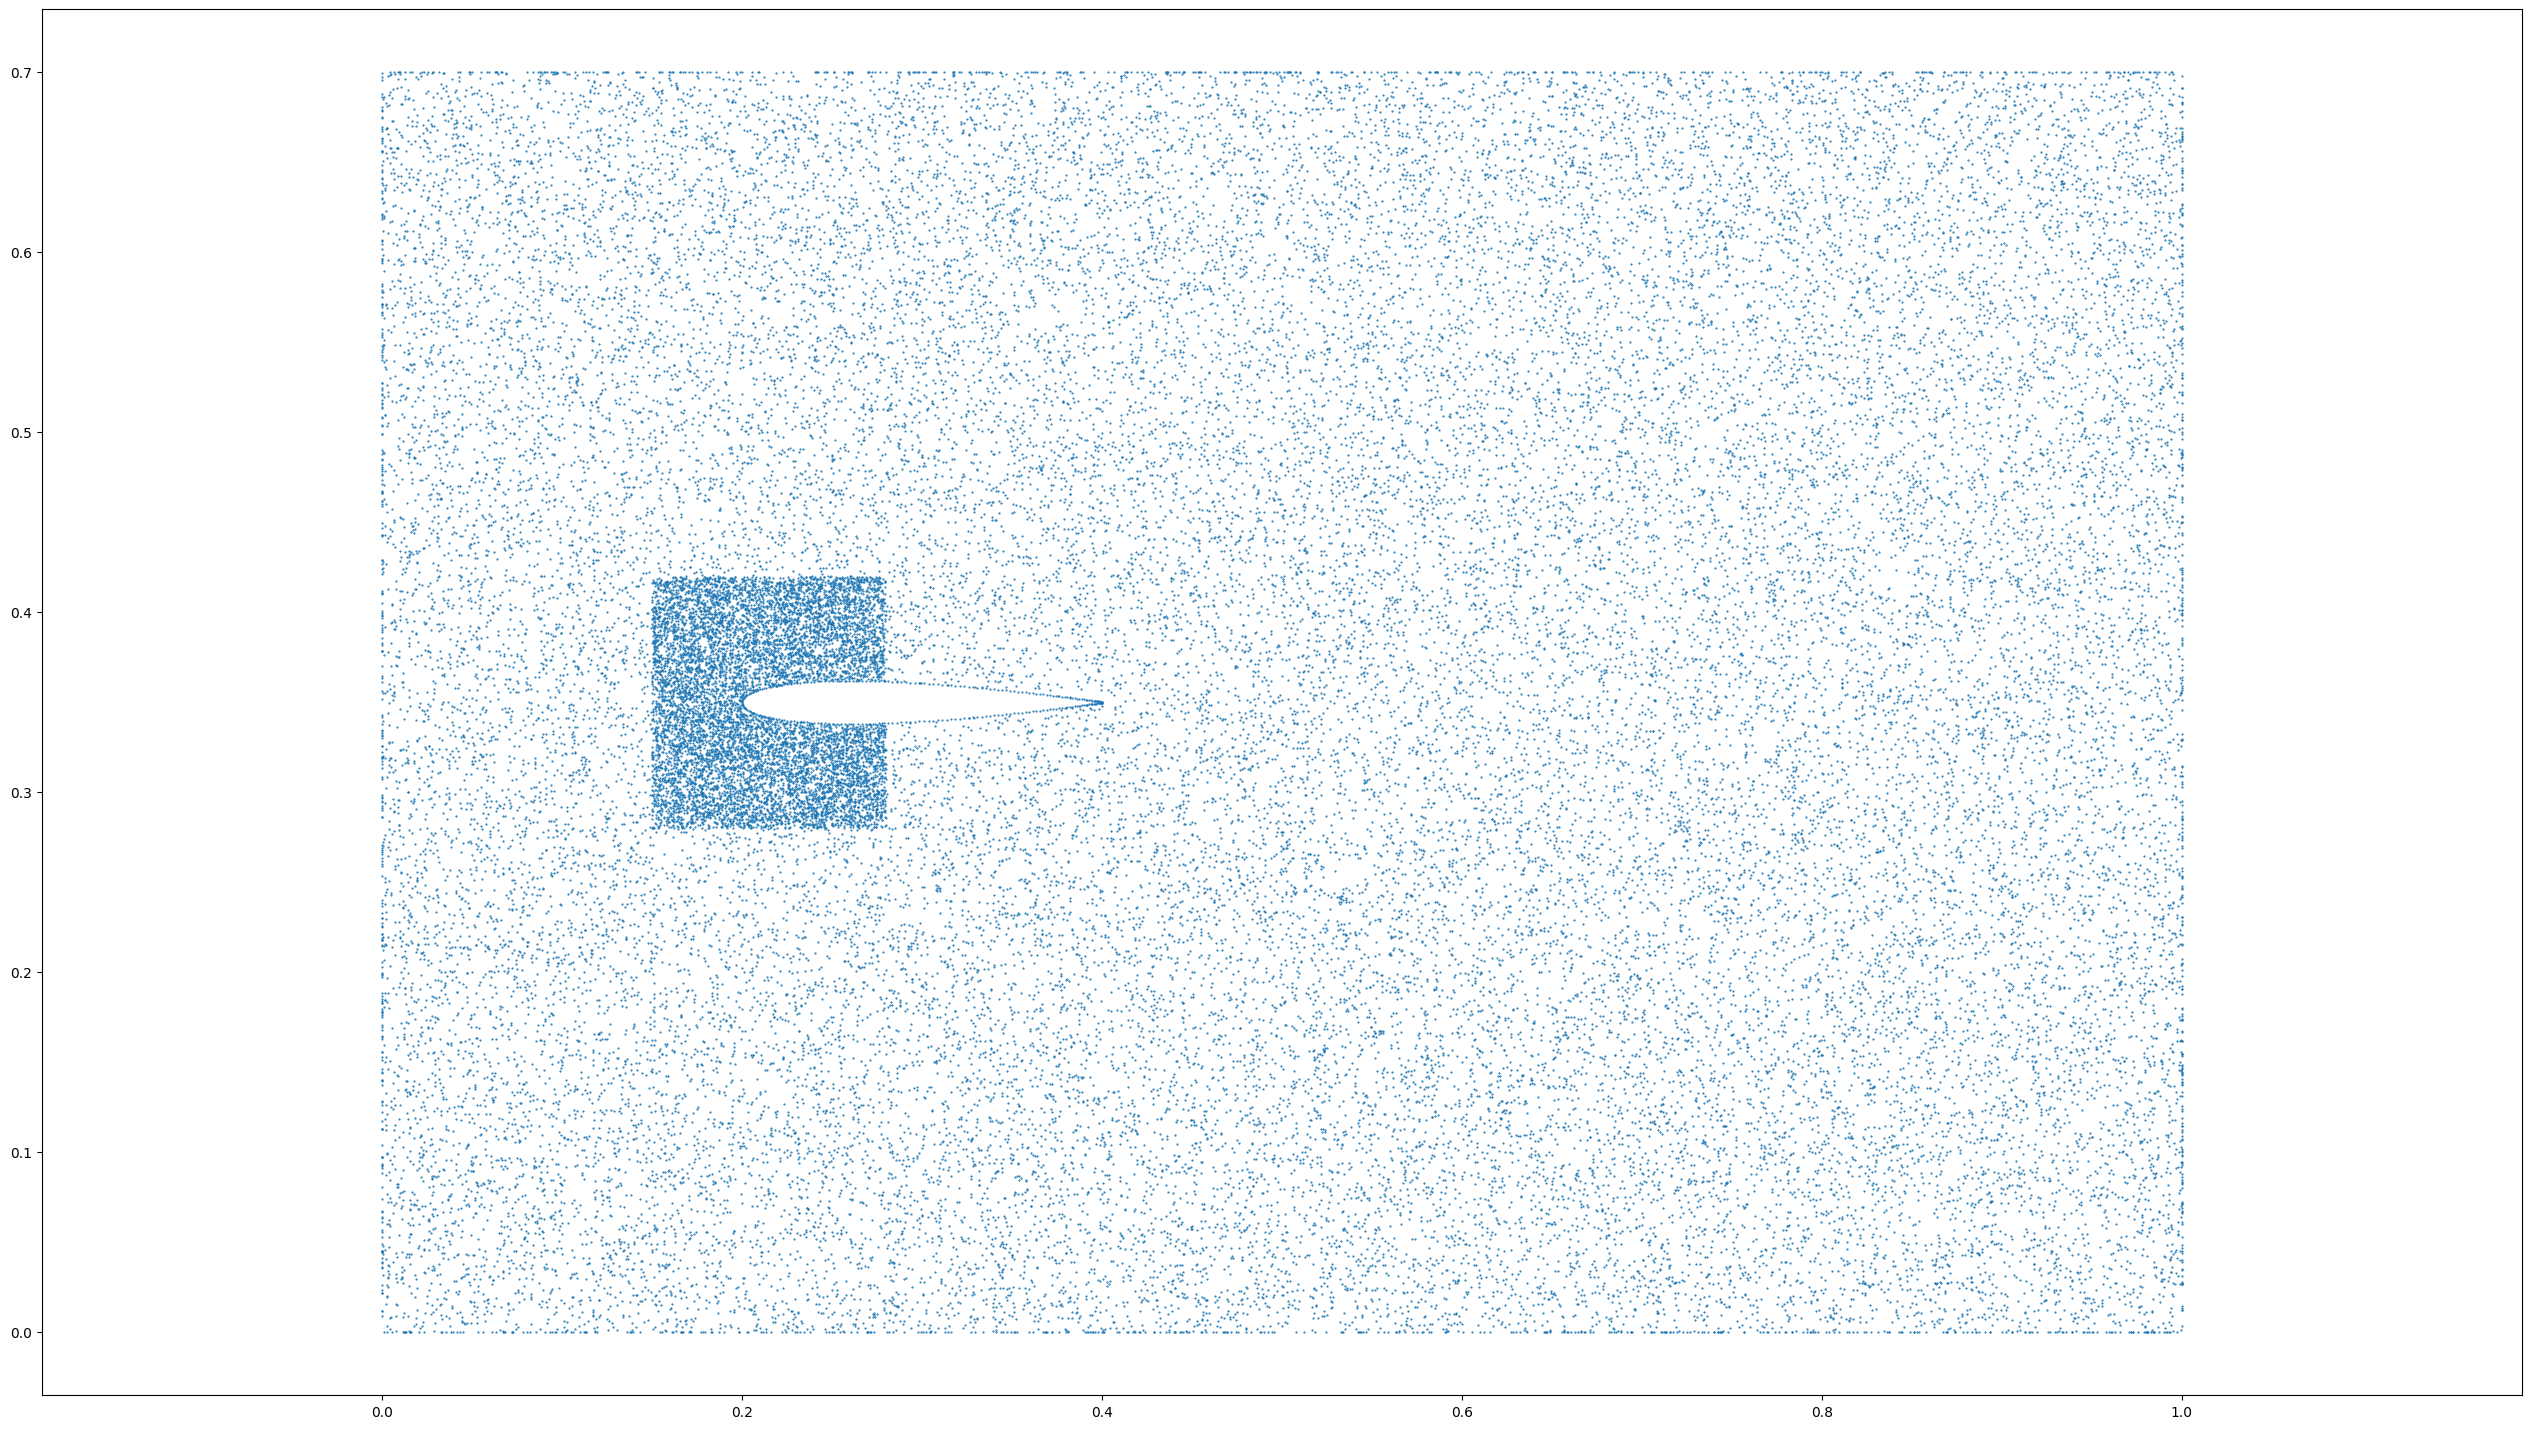

In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

# set domain
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 0.7

# equation constants
rho  = 1.0
mu   = 0.02
umax = 1.0

def boundaryNACA4D(M, P, SS, c, n, offset_x, offset_y):
    """
    Compute the coordinates of a NACA 4-digits airfoil
    
    Args:
        M:  maximum camber value (*100)
        P:  position of the maximum camber alog the chord (*10)
        SS: maximum thickness (*100)
        c:  chord length
        n:  the total points sampled will be 2*n
    """
    m = M / 100
    p = P / 10
    t = SS / 100
    
    if (m == 0):
        p = 1
    
    # Chord discretization (cosine discretization)
    xv = np.linspace(0.0, c, n+1)
    xv = c / 2.0 * (1.0 - np.cos(np.pi * xv / c))
    
    # Thickness distribution
    ytfcn = lambda x: 5 * t * c * (0.2969 * (x / c)**0.5 - 
                                   0.1260 * (x / c) - 
                                   0.3516 * (x / c)**2 + 
                                   0.2843 * (x / c)**3 - 
                                   0.1015 * (x / c)**4)
    yt = ytfcn(xv)
    
    # Camber line
    yc = np.zeros(np.size(xv))
    
    for ii in range(n+1):
        if xv[ii] <= p * c:
            yc[ii] = c * (m / p**2 * (xv[ii] / c) * (2 * p - (xv[ii] / c)))
        else:
            yc[ii] = c * (m / (1 - p)**2 * (1 + (2 * p - (xv[ii] / c)) * (xv[ii] / c) - 2 * p))
    
    # Camber line slope
    dyc = np.zeros(np.size(xv))
    
    for ii in range(n+1):
        if xv[ii] <= p * c:
            dyc[ii] = m / p**2 * 2 * (p - xv[ii] / c)
        else:
            dyc[ii] = m / (1 - p)**2 * 2 * (p - xv[ii] / c)
            
    # Boundary coordinates and sorting        
    th = np.arctan2(dyc, 1)
    xU = xv - yt * np.sin(th)
    yU = yc + yt * np.cos(th)
    xL = xv + yt * np.sin(th)
    yL = yc - yt * np.cos(th)
    
    x = np.zeros(2 * n + 1)
    y = np.zeros(2 * n + 1)
    
    for ii in range(n):
        x[ii] = xL[n - ii]
        y[ii] = yL[n - ii]
        
    x[n : 2 * n + 1] = xU
    y[n : 2 * n + 1] = yU
    
    return np.vstack((x + offset_x, y + offset_y)).T

def navier_stokes(x, y):
    """
    System of PDEs to be minimized: incompressible Navier-Stokes equation in the
    continuum-mechanics based formulations.
    
    """
    psi, p, sigma11, sigma22, sigma12 = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5]
    
    u =   dde.grad.jacobian(y, x, i = 0, j = 1)
    v = - dde.grad.jacobian(y, x, i = 0, j = 0)
    
    u_x = dde.grad.jacobian(u, x, i = 0, j = 0)
    u_y = dde.grad.jacobian(u, x, i = 0, j = 1)
    
    v_x = dde.grad.jacobian(v, x, i = 0, j = 0)
    v_y = dde.grad.jacobian(v, x, i = 0, j = 1)
    
    sigma11_x = dde.grad.jacobian(y, x, i = 2, j = 0)
    sigma12_x = dde.grad.jacobian(y, x, i = 4, j = 0)
    sigma12_y = dde.grad.jacobian(y, x, i = 4, j = 1)
    sigma22_y = dde.grad.jacobian(y, x, i = 3, j = 1)
    
    continuumx = rho * (u * u_x + v * u_y) - sigma11_x - sigma12_y
    continuumy = rho * (u * v_x + v * v_y) - sigma12_x - sigma22_y
    
    constitutive1 = - p + 2 * mu * u_x - sigma11
    constitutive2 = - p + 2 * mu * v_y - sigma22
    constitutive3 = mu * (u_y + v_x) - sigma12
    constitutive4 = p + (sigma11 + sigma22) / 2
    
    return continuumx, continuumy, constitutive1, constitutive2, constitutive3, constitutive4

# Geometry defintion
farfield = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
airfoil  = dde.geometry.Polygon(boundaryNACA4D(0, 0, 12, 0.2, 250, 0.20, 0.35))
geom     = dde.geometry.CSGDifference(farfield, airfoil)

inner_rec  = dde.geometry.Rectangle([0.15, 0.28], [0.28, 0.42])
outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil)
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil)

inner_points = inner_dom.random_points(10000)
outer_points = outer_dom.random_points(40000)

farfield_points = farfield.random_boundary_points(1280)
airfoil_points  = boundaryNACA4D(0, 0, 12, 0.2, 125, 0.20, 0.35)

points = np.append(inner_points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

# Boundaries definition
def boundary_farfield_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], xmin)

def boundary_farfield_top_bottom(x, on_boundary):
    return on_boundary and (np.isclose(x[1], ymax) or np.isclose(x[1], ymin))

def boundary_farfield_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], xmax)

def boundary_airfoil(x, on_boundary):
    return on_boundary and (not farfield.on_boundary(x))

# Boundary values definition
def fun_u_farfield(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1) - 1.0

def fun_no_slip_u(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def fun_no_slip_v(x, y, _):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def funP(x):
    return 0.0
  
# Boundary conditions assembly   
bc_inlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_farfield_inlet)
bc_inlet_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_farfield_inlet)

bc_top_bottom_u = dde.OperatorBC(geom, fun_u_farfield, boundary_farfield_top_bottom)
bc_top_bottom_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_farfield_top_bottom)

bc_outlet_p = dde.DirichletBC(geom, funP, boundary_farfield_outlet, component = 1)

bc_airfoil_u = dde.OperatorBC(geom, fun_no_slip_u, boundary_airfoil)
bc_airfoil_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_airfoil)

bcs = [bc_inlet_u, bc_inlet_v, bc_top_bottom_u, bc_top_bottom_v, bc_outlet_p, bc_airfoil_u, bc_airfoil_v]

# Problem setup
data = dde.data.PDE(geom, navier_stokes, bcs, num_domain = 0, num_boundary = 0, num_test = 5000, anchors = points)

plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

dde.config.set_default_float('float64')
# Neural network definition
layer_size  = [2] + [40] * 8 + [5]
activation  = 'tanh' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)



In [2]:
# Model definition
model = dde.Model(data, net)
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs
    
losshistory, train_state = model.train(epochs = 1000, display_every = 100, model_save_path = './')
dde.saveplot(losshistory, train_state, issave = True, isplot = True)

model.compile(optimizer = 'L-BFGS-B', loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
model.train_step.optimizer_kwargs = {'options': {'maxcor': 50, 
                                                   'ftol': 1.0 * np.finfo(float).eps, 
                                                   'maxfun':  50000, 
                                                   'maxiter': 50000, 
                                                   'maxls': 50}}
losshistory, train_state = model.train(display_every = 100, model_save_path = './')
dde.saveplot(losshistory, train_state, issave = True, isplot = True)




Compiling model...
'compile' took 0.000925 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [2.63e-01, 9.70e-03, 2.09e-01, 1.09e-02, 2.93e-02, 6.89e-02, 4.16e+00, 1.24e-02, 3.84e+00, 5.19e-03, 1.75e-01, 3.79e-01, 3.80e-03]    [2.59e-01, 9.14e-03, 2.31e-01, 1.30e-02, 3.03e-02, 7.85e-02, 4.16e+00, 1.24e-02, 3.84e+00, 5.19e-03, 1.75e-01, 3.79e-01, 3.80e-03]    []  
100       [3.97e-04, 1.95e-04, 7.83e-04, 1.13e-04, 3.19e-05, 3.64e-04, 2.29e-01, 5.74e-04, 3.08e-01, 1.93e-03, 8.41e-05, 8.61e-01, 4.76e-05]    [4.34e-04, 1.58e-04, 9.07e-04, 1.27e-04, 3.70e-05, 4.18e-04, 2.29e-01, 5.74e-04, 3.08e-01, 1.93e-03, 8.41e-05, 8.61e-01, 4.76e-05]    []  
200       [1.25e-03, 1.50e-03, 3.39e-05, 1.60e-05, 3.04e-04, 1.60e-05, 1.94e-01


KeyboardInterrupt



In [3]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(xmin, xmax + dy, dx)
y = np.arange(ymin, ymax + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

def getU(x, y):   
    return dde.grad.jacobian(y, x, i = 0, j = 1) 

def getV(x, y): 
    return - dde.grad.jacobian(y, x, i = 0, j = 0)  

def getP(x, y):
    return y[:, 1:2]

# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

#for i in range(len(X)):
#    if airfoil.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0
        
u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))


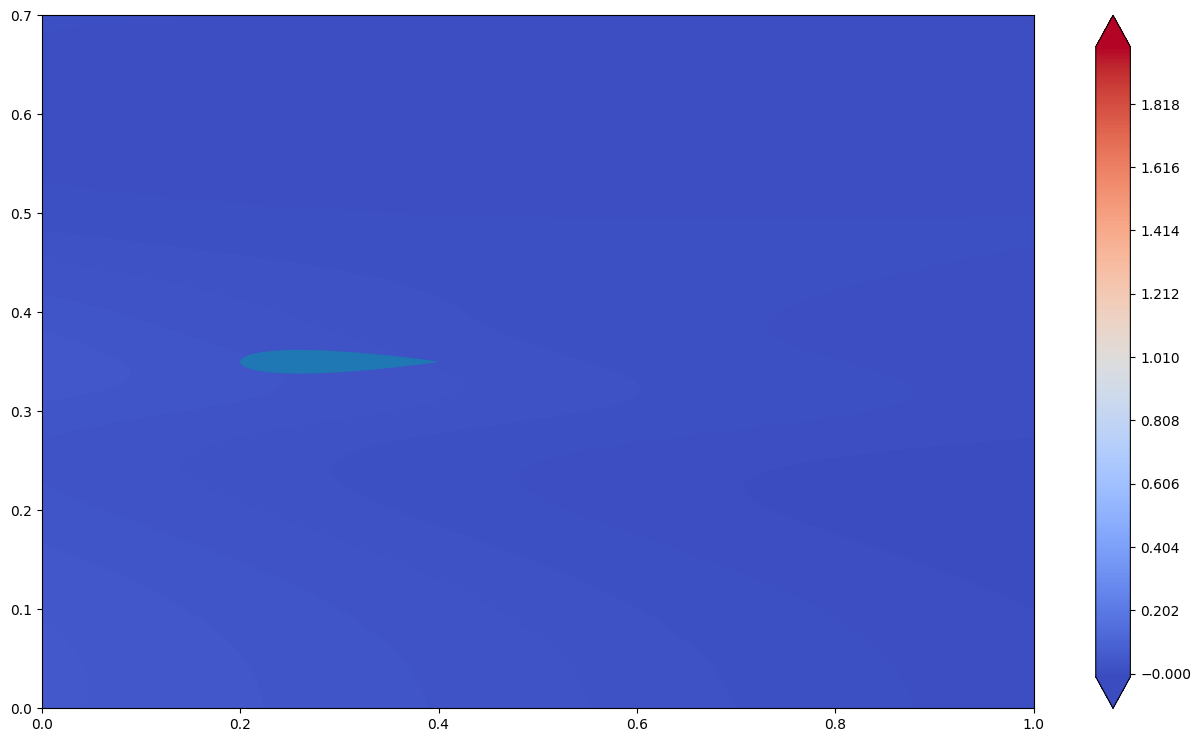

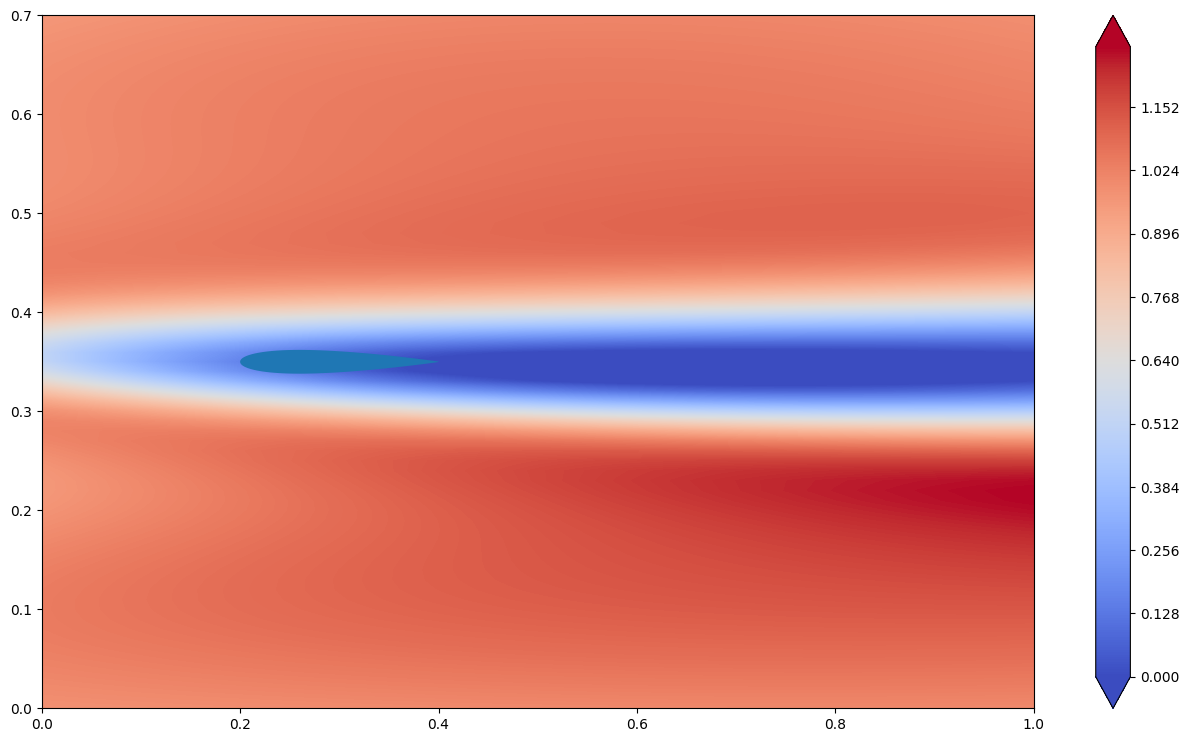

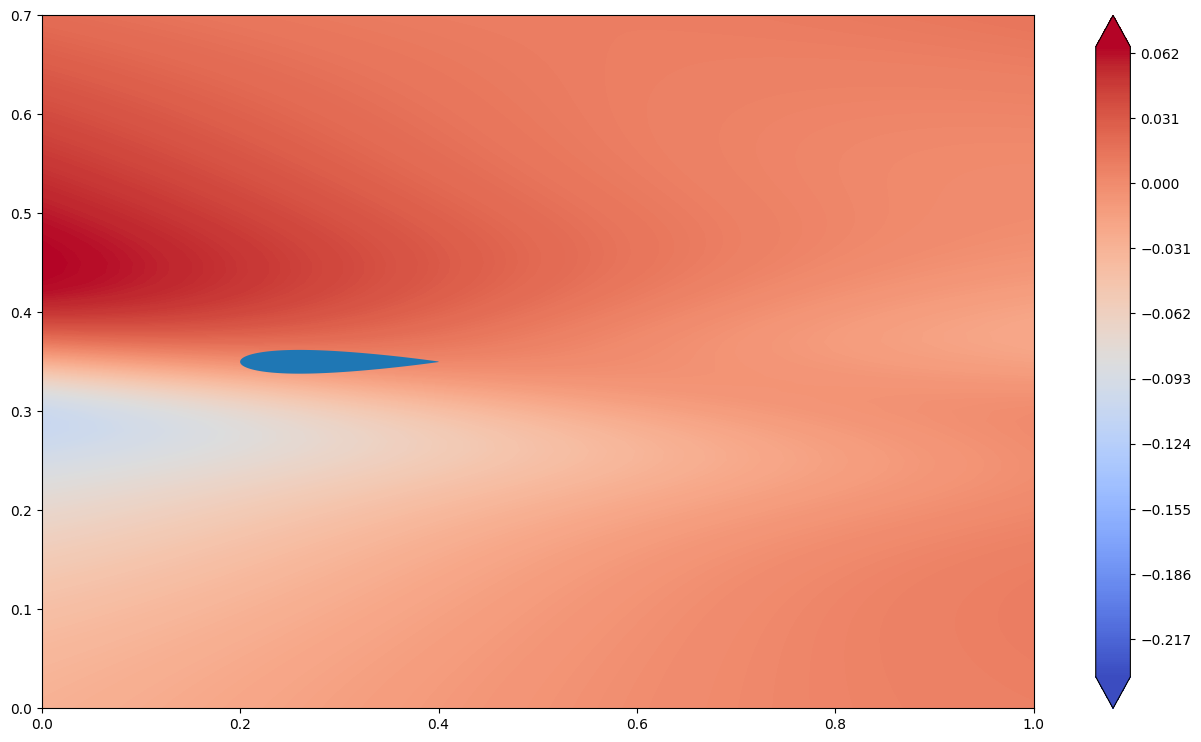

In [5]:
airfoil_plot = boundaryNACA4D(0, 0, 12, 0.2, 150, offset_x = 0.20, offset_y = 0.35)

fig1, ax1 = plt.subplots(figsize = (16, 9))
#ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(p.min(), 2, 0.001)
cnt1 = ax1.contourf(x, y, p, clev, cmap = plt.cm.coolwarm, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('NACA0012NS0.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
#ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(0, u.max(), 0.001)
cnt2 = ax2.contourf(x, y, u, clev, cmap = plt.cm.coolwarm, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig('NACA0012NS1.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
#ax3.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(-0.235, v.max(), 0.001)
cnt3 = ax3.contourf(x, y, v, clev, cmap = plt.cm.coolwarm, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig('NACA0012NS2.png')